<a href="https://www.kaggle.com/code/averma111/pytorch-image-matching?scriptVersionId=129481960" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

In [56]:
import os
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import cv2
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [14]:
root = '/kaggle/input/image-matching-challenge-2023'
train_label_file = 'train_labels.csv'
train_path = '/kaggle/input/image-matching-challenge-2023/train'
test_path ='/kaggle/input/image-matching-challenge-2023/test'

In [15]:
def get_datasets(root,path):
    file_path = os.path.join(root,path)
    df = pd.read_csv(file_path)
    return df

In [16]:
get_datasets(train_path,train_label_file).head()

,dataset,scene,image_path,rotation_matrix,translation_vector
0,urban,kyiv-puppet-theater,urban/kyiv-puppet-theater/images/IMG_20220127_...,0.961211667939937;0.012901284585988954;0.27550...,-15.272578207792487;-0.6299638684926413;21.960...
1,urban,kyiv-puppet-theater,urban/kyiv-puppet-theater/images/IMG_20220127_...,0.9983992256415107;0.03067020011152836;0.04752...,-10.86744827847772;5.142649233329267;22.080480...
2,urban,kyiv-puppet-theater,urban/kyiv-puppet-theater/images/IMG_20220127_...,-0.00887553412819142;-0.176226804404349;-0.984...,21.65171058540772;5.995022279588175;8.02005533...
3,urban,kyiv-puppet-theater,urban/kyiv-puppet-theater/images/IMG_20220127_...,-0.9161929266043187;-0.08177524286162957;-0.39...,9.821364270813396;4.839277289238847;19.6308283...
4,urban,kyiv-puppet-theater,urban/kyiv-puppet-theater/images/IMG_20220127_...,0.9917061795507187;0.02380210836276639;0.12630...,-25.98610607878878;1.9810845701842204;-1.04975...


In [43]:
train_transform = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
    ])

validation_transform = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
    ])

print("Follwing classes are there : \n",train_dataset.classes)

Follwing classes are there : 
 ['haiper', 'heritage', 'phototourism', 'urban']


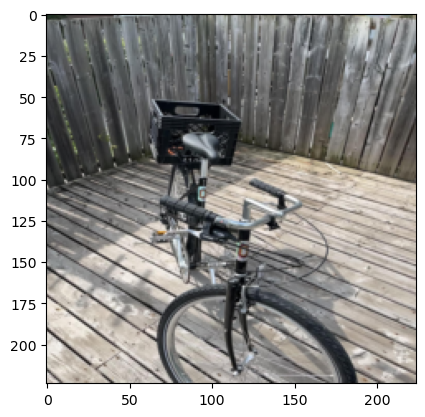

In [29]:
def display_image(image,label):
     plt.imshow(image.permute(1,2,0))

display_image(*train_dataset[2])

In [30]:
class ImageDataset(Dataset):
    def __init__(self, root, img_path, rotation_label, translation_label, transforms=None):
        self.root = root
        self.img_path_list = img_path
        self.rotation_label_list = rotation_label
        self.translation_label_list = translation_label
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path[index]
        img_path = self.root + img_path
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        rotation_label = self.rotation_label_list[index].split(";")
        rotation_label = list(map(float, rotation_label))
        
        translation_label = self.translation_label_list[index].split(";")
        translation_label = list(map(float, translation_label))
        
        return image, np.array(rotation_label), np.array(translation_label)
        
    def __len__(self):
        return len(self.img_path_list)

In [37]:
def get_train_validation_set(df):
    validtion_data = df.sample(frac=0.3)
    training_data =  df[~df["image_path"].isin(validtion_data["image_path"])]
    return training_data,validtion_data


training_data,validation_data = get_train_validation_set(get_datasets(train_path,train_label_file))

In [38]:
def get_translation_rotation(df):
    df["rotation_matrix_split"] = df.apply(lambda x:list(map(float, x["rotation_matrix"].split(";"))), axis=1)
    df["translation_vector_split"] = df.apply(lambda x:list(map(float, x["translation_vector"].split(";"))), axis=1)
    rotation_value = np.array(df["rotation_matrix_split"].tolist())
    translation_value = np.array(df["translation_vector_split"].tolist())
    
    return translation_value,rotation_value

translation_value,rotation_value = get_translation_rotation(get_datasets(train_path,train_label_file))

In [58]:
def get_train_dataset(train_path,traning_data):
    train_dataset = ImageDataset(train_path, 
                        training_data["image_path"].tolist(), 
                        training_data["rotation_matrix"].tolist(), 
                        training_data["translation_vector"].tolist(), 
                        transforms=train_transform)
    return train_dataset

In [59]:
def get_validation_dataset(train_path,validation_data):    
    validation_dataset = ImageDataset(train_path, 
                        validation_data["image_path"].tolist(), 
                        validation_data["rotation_matrix"].tolist(), 
                        validation_data["translation_vector"].tolist(), 
                        transforms=validation_transform)
    return validation_dataset

In [60]:
def get_dataloader(train_dataset,validation_dataset):
    train_loader = DataLoader(train_dataset, batch_size = 4, shuffle=True, num_workers=2)
    validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False)
    return train_loader,validation_loader
    
train_loader,validation_loader = get_dataloader(get_train_dataset(train_path,training_data),get_validation_dataset(train_path,validation_data))

In [61]:
class ImagemtachingModel(torch.nn.Module):
    def __init__(self, dropout=0.2):
        super(ImagemtachingModel, self).__init__()
        self.layer_one = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64), 
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2))
        
        self.layer_tow = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2))
        
        self.layer_three = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256), 
            nn.ReLU(), 
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2))
        
        self.layer_four = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU(), 
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2))
        
        self.layer_five = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512), 
            nn.ReLU(), 
            nn.Dropout(dropout),
            nn.MaxPool2d(kernel_size=2), 
            nn.AvgPool2d(kernel_size=7))
        
        self.layer_six = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
        )
        self.rotation_out = nn.Linear(512, 9)
        self.tanh = torch.nn.Tanh()
        
        self.translation_out = torch.nn.Linear(512, 3)
        
    def forward(self, x):
        x = self.layer_one(x)
        x = self.layer_two(x)
        x = self.layer_three(x)
        x = self.layer_four(x)
        x = self.layer_five(x)
        
        x = x.view(-1, 512)
        x = self.layer_six(x)
        
        rotation_out = self.rotation_out(x)
        rotation_out = self.tanh(rotation_out)
        
        translation_out = self.translation_out(x)
        
        return rotation_out, translation_out

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [63]:
model = ImagemtachingModel(dropout=0.2)
model.to(device)

ImagemtachingModel(
  (layer_one): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_tow): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): MaxPool2d(kernel_size=2, st

In [64]:
l1_distance = torch.nn.L1Loss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)
best_loss = 1000000000
epochs = 10
best_model = None

In [65]:
for epoch in range(1, epochs+1):
    
    train_loss = []
    rot_loss = []
    trans_loss = []
    
    val_loss = []
    val_rot_loss = []
    val_trans_loss = []
    
    for imgs, rotation_labels, translation_labels in tqdm(train_loader):
        model.train()
        optimizer.zero_grad()
        
        imgs = imgs.to(device)
        rotation_labels = rotation_labels.to(device)
        translation_labels = translation_labels.to(device)
        
        rotation_output, translation_output = model(imgs)
        
        rotation_loss = l1_distance(rotation_output, rotation_labels)
        translation_loss = l1_distance(translation_output, translation_labels)
        loss = rotation_loss + translation_loss
        loss.backward()
        
        optimizer.step()
        
        train_loss.append(loss.item())
        rot_loss.append(rotation_loss.item())
        trans_loss.append(translation_loss.item())

    for imgs, rotation_labels, translation_labels in tqdm(val_loader):
        model.eval()
        
        imgs = imgs.to(device)
        rotation_labels = rotation_labels.to(device)
        translation_labels = translation_labels.to(device)
        
        rotation_output, translation_output = model(imgs)
        rotation_loss = l1_distance(rotation_output, rotation_labels)
        translation_loss = l1_distance(translation_output, translation_labels)
        loss = rotation_loss + translation_loss
        
        val_loss.append(loss.item())
        val_rot_loss.append(rotation_loss.item())
        val_trans_loss.append(translation_loss.item())
        
    mtrain_loss = np.mean(train_loss)
    mval_loss = np.mean(val_loss)
    mtrain_rot_loss = np.mean(rot_loss)
    mtrain_trans_loss = np.mean(trans_loss)
    mval_rot_loss = np.mean(val_rot_loss)
    mval_trans_loss = np.mean(val_trans_loss)
    
    print(f'Epoch [{epoch}], Train Loss : [{mtrain_loss:.5f}] \
    Train Rotation Loss : [{mtrain_rot_loss:.5f}] Train Translation Loss : [{mtrain_trans_loss:.5f}] \
          Val Loss : [{mval_loss:.5f}] Val Rotation Loss : [{mval_rot_loss:.5f}] Val Translation Loss : [{mval_trans_loss:.5f}]')

    if scheduler is not None:
        scheduler.step(mval_loss)

    if best_loss < mval_loss:
        best_loss = mval_loss
        best_model = model

  0%|          | 0/58 [00:00<?, ?it/s]

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_23/3727055824.py", line 10, in __getitem__
    img_path = self.img_path[index]
AttributeError: 'ImageDataset' object has no attribute 'img_path'
